In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
years = range(2000,2020,4)
df = pd.read_csv('counties.csv')

In [3]:
data = df.drop(columns=['state', 'county'])
data = data.dropna(axis=0,how='any')
data.describe()

,2000D,2000R,2000O,2004D,2004R,2004O,2008D,2008R,2008O,2012D,2012R,2012O,2016D,2016R,2016O
count,2.875000e+03,2875.000000,2875.000000,2.875000e+03,2.875000e+03,2875.000000,2.875000e+03,2875.000000,2875.000000,2.875000e+03,2875.000000,2875.000000,2.875000e+03,2875.000000,2875.000000
mean,1.699424e+04,16533.856000,1352.073391,1.956915e+04,2.028555e+04,508.671652,2.298134e+04,19539.632696,610.991304,2.171365e+04,19761.090783,886.516522,2.175607e+04,20524.178783,2543.772522
std,5.942532e+04,39923.542134,4232.141433,6.769202e+04,4.869764e+04,1976.171276,7.944593e+04,45955.629730,1913.652362,7.628626e+04,45649.528293,3056.034805,8.298175e+04,44262.493478,7726.198627
min,1.400000e+01,106.000000,3.000000,1.200000e+01,6.500000e+01,0.000000,8.000000e+00,67.000000,0.000000,5.000000e+00,54.000000,1.000000,4.000000e+00,58.000000,3.000000
25%,1.751500e+03,2689.000000,109.000000,1.882500e+03,3.124500e+03,43.000000,1.930500e+03,2956.000000,78.500000,1.662500e+03,3021.500000,84.000000,1.240000e+03,3346.000000,195.000000
50%,3.830000e+03,5363.000000,278.000000,4.177000e+03,6.522000e+03,98.000000,4.493000e+03,6297.000000,182.000000,4.014000e+03,6398.000000,195.000000,3.199000e+03,7194.000000,529.000000
75%,9.580500e+03,13166.000000,886.500000,1.078350e+04,1.646800e+04,302.000000,1.262450e+04,16042.000000,453.500000,1.147700e+04,16391.500000,564.000000,9.940500e+03,17945.500000,1736.500000
max,1.710505e+06,871930.000000,112719.000000,1.907736e+06,1.076225e+06,39515.000000,2.295853e+06,956425.000000,65970.000000,2.216903e+06,885333.000000,78831.000000,2.464364e+06,769743.000000,200201.000000


In [4]:
data = data.to_numpy(dtype=np.int64)

In [5]:
def plotCounty(state,county,d,r,o,predicted=None):
    years = range(2000,2020,4)
    plt.figure()
    plt.plot(years,d,'b',label='Democrat')
    plt.plot(years,r,'r',label='Republican')
    plt.plot(years,o,'y',label='Other')
    plt.plot(years,d+r+o,'k',label='Total')
    if predicted is not None:
        new_years = range(2008,2024,4)
        plt.plot(new_years,predicted[0]*20000,'c',label='Democrat Model')
        plt.plot(new_years,predicted[1]*20000,'m',label='Republican Model')
        plt.plot(new_years,predicted[2]*250,'g',label='Other Model')
    plt.xlabel('Year')
    plt.ylabel('Votes')
    plt.title(county+', '+state)
    plt.xticks(years)
    plt.legend()
    plt.show()

In [25]:
def calcState(state):
    state_df = df[df['state']==state]
    state_df = state_df.drop(columns=['state','county'])
    state_votes = state_df.values.tolist()
    state_votes = np.array(state_votes)
    state_votes = np.sum(state_votes,axis=0,dtype=np.int64)
    d = []
    r = []
    o = []
    for ind, val in enumerate(state_votes):
        party = ind % 3
        if party == 0:
            d.append(val)
        elif party == 1:
            r.append(val)
        else:
            o.append(val)
    d = np.array(d)
    r = np.array(r)
    o = np.array(o)
    return d,r,o

In [26]:
def plotState(state,d,r,o):
    years = range(2000,2020,4)
    plt.figure()
    plt.plot(years,d,'b',label='Democrat')
    plt.plot(years,r,'r',label='Republican')
    plt.plot(years,o,'y',label='Other')
    plt.plot(years,d+r+o,'k',label='Total')
    plt.xlabel('Year')
    plt.ylabel('Votes')
    plt.title(state)
    plt.xticks(years)
    plt.legend()
    plt.show()

In [6]:
def convertbyParty(point):
    d = point[:,::3]/20000
    r = point[:,1::3]/20000
    o = point[:,2::3]/250
    return d,r,o
print(df.loc[0])
convertbyParty(np.expand_dims(df.loc[0].values[2:],0))

state          AL
county    Autauga
2000D        4942
2000R       11993
2000O         273
2004D        4758
2004R       15196
2004O         127
2008D        6093
2008R       17403
2008O         145
2012D        6363
2012R       17379
2012O         190
2016D        5936
2016R       18172
2016O         865
Name: 0, dtype: object


(array([[0.2471, 0.2379, 0.30465, 0.31815, 0.2968]], dtype=object),
 array([[0.59965, 0.7598, 0.87015, 0.86895, 0.9086]], dtype=object),
 array([[1.092, 0.508, 0.58, 0.76, 3.46]], dtype=object))

In [78]:
def getDataset(data,batch_size,split=True):
    data = np.expand_dims(data,axis=-1)
    if split:
        np.random.shuffle(data)
    num = data.shape[0]
    train_data = data[:int(num*0.6)]
    val_data = data[int(num*0.6):int(num*0.8)]
    test_data = data[int(num*0.8):]
    def createDS(point,label=True):
        d,r,o=convertbyParty(point)
        new_data = np.vstack((d,r,o))
        if label:
            new_data = np.vstack((new_data,new_data*1.5))
        ds = tf.data.Dataset.from_tensor_slices(new_data)
        if label:
            ds = ds.map(lambda p: (p[:-1],p[1:]))
        else:
            ds = ds.map(lambda p: p[1:])
        return ds.batch(batch_size).prefetch(1) if label else ds
    if split:
        return createDS(train_data),createDS(val_data),createDS(test_data)
    else:
        return createDS(data,False).batch(100000)

In [46]:
train_ds, val_ds, test_ds = getDataset(data,8)
# list(getDataset(data,1,False))[:3]


[<tf.Tensor: shape=(1, 4, 1), dtype=float64, numpy=
 array([[[0.25355],
         [0.2673 ],
         [0.3604 ],
         [0.28895]]])>,
 <tf.Tensor: shape=(1, 4, 1), dtype=float64, numpy=
 array([[[0.0241],
         [0.0204],
         [0.0218],
         [0.0162]]])>,
 <tf.Tensor: shape=(1, 4, 1), dtype=float64, numpy=
 array([[[0.14165],
         [0.14605],
         [0.1328 ],
         [0.11325]]])>]

In [26]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv1D(2,2,activation='relu',input_shape=(4,1)),
#     tf.keras.layers.Conv1D(2,2,activation='relu'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(4,activation='relu'),
#     tf.keras.layers.Reshape((4,1)),
#     tf.keras.layers.LSTM(8,return_sequences=True),
#     tf.keras.layers.LSTM(8,return_sequences=True),
#     tf.keras.layers.LSTM(8,return_sequences=True),
# ])

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(8,2,input_shape=(4,1),activation='relu'),
    tf.keras.layers.Conv1D(8,2,activation='relu'),
    tf.keras.layers.LSTM(12,return_sequences=True),
    tf.keras.layers.LSTM(12,return_sequences=True),
    tf.keras.layers.LSTM(12,return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4),
    tf.keras.layers.Reshape((4,1))
])

In [36]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=['mae','mse'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 3, 4)              12        
_________________________________________________________________
lstm_11 (LSTM)               (None, 3, 8)              416       
_________________________________________________________________
lstm_12 (LSTM)               (None, 3, 16)             1600      
_________________________________________________________________
flatten_4 (Flatten)          (None, 48)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 196       
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 1)              0         
Total params: 2,224
Trainable params: 2,224
Non-trainable params: 0
____________________________________________________

In [37]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint4.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=125)


In [ ]:
# history = model.fit(train_ds,epochs=100,validation_data=val_ds,callbacks=[lr_schedule])
# plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-6, 10, 0, 3])
def getlr(epoch):
  return 1e-5
new_lr = tf.keras.callbacks.LearningRateScheduler(getlr)
model.fit(train_ds,epochs=10000,validation_data=val_ds,callbacks=[model_checkpoint,early_stopping,new_lr])

Epoch 1/10000
1294/1294 [==============================] - 8s 6ms/step - loss: 0.3164 - mae: 0.3858 - mse: 57.9642 - val_loss: 0.1509 - val_mae: 0.2194 - val_mse: 2.5308
Epoch 2/10000
1294/1294 [==============================] - 8s 6ms/step - loss: 0.3164 - mae: 0.3850 - mse: 57.9582 - val_loss: 0.1508 - val_mae: 0.2187 - val_mse: 2.5299
Epoch 3/10000
1294/1294 [==============================] - 8s 6ms/step - loss: 0.3163 - mae: 0.3848 - mse: 57.9619 - val_loss: 0.1508 - val_mae: 0.2184 - val_mse: 2.5325
Epoch 4/10000
1294/1294 [==============================] - 8s 6ms/step - loss: 0.3163 - mae: 0.3847 - mse: 57.9619 - val_loss: 0.1508 - val_mae: 0.2182 - val_mse: 2.5324
Epoch 5/10000
1294/1294 [==============================] - 8s 6ms/step - loss: 0.3163 - mae: 0.3846 - mse: 57.9605 - val_loss: 0.1508 - val_mae: 0.2181 - val_mse: 2.5328
Epoch 6/10000
1294/1294 [==============================] - 8s 6ms/step - loss: 0.3162 - mae: 0.3845 - mse: 57.9582 - val_loss: 0.1508 - val_mae: 0.218

In [98]:
c = 'Adair'
s = 'OK'
r = df[(df['state']==s)&(df['county']==c)]

In [99]:
model4 = tf.keras.models.load_model('checkpoint2.h5')
row = r.drop(columns=['state','county'])
row = row.to_numpy()
dataset = getDataset(row,8,False)

In [100]:
results = model4.predict(dataset)

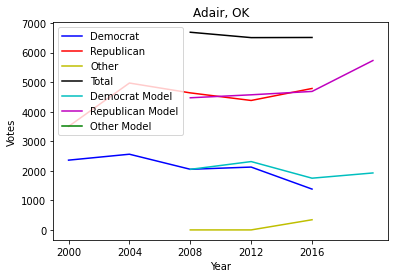

In [101]:
dem = np.array(r.values.tolist()[0][2::3])
gop = np.array(r.values.tolist()[0][3::3])
other = np.array(r.values.tolist()[0][4::3])
plotCounty(s,c,dem,gop,other,results)